<a href="https://colab.research.google.com/github/run-llama/llama_index/blob/main/docs/docs/examples/vector_stores/FirestoreVectorStore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1

The proposed method starts with preprocessing the input signals. This step includes three main steps:
* (1) Converting to mono-channel
* (2) Converting signal frequency
* (3) Signal normalization

The purpose of the pre-processing step is to remove redundant data from the audio signal, convert all signals into a standard intermediate form and prepare them for use in the next steps. For this purpose, the processes of audio signal normalization, audio signal sampling, and transformation of two-channel signals into mono-channel vector form are used. In this way, at the beginning of the pre-processing step, the two-channel nature of the input audio signal is checked. If the signal is two (or more)-channel, we convert it to a mono-channel signal. Since audio signals are recorded in different conditions and by different devices; Therefore, the frequency of some input signals may be different from other signals. For this reason, in the second step of the pre-processing phase, all the vectors of the input signal are converted to the same frequency of 16 kHz. At the end of the pre-processing step, the signal vector is converted into a vector with zero mean and unit variance, so that the special conditions of a signal (high or low volume) are eliminated as much as possible. 


In [1]:
# Import libraries 
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import glob 
from sklearn.metrics import confusion_matrix
import IPython.display as ipd  # To play sound in the notebook
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import preprocessing
import sys
import warnings

import soundfile as sf

# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [3]:
EMODB = "C:/Users/Jeffe/Downloads/archive/wav"

## Create emodb_features.csv 
This code processes audio files from the **EMODB (Emotional Speech Database)** to create a structured CSV file containing metadata about each audio file. It traverses the directory containing the EMODB dataset, identifies `.wav` files, and extracts metadata such as the speaker's gender (determined by a mapping of speaker IDs) and the emotion conveyed in the speech (determined by an emotion code in the filename). 

The script constructs a list of dictionaries, where each dictionary represents an audio file and includes the gender, emotion label, file path, and data source. This information is then converted into a Pandas DataFrame and saved as a CSV file named `emodb_features.csv`. The CSV serves as a feature extraction summary, which can be used for further analysis or modeling in tasks such as emotion recognition from speech.

In [4]:
# Define mappings for emotions and genders
emotion_mapping = {
    'W': 'anger',
    'L': 'boredom',
    'E': 'disgust',
    'A': 'fear',
    'F': 'happiness',
    'T': 'sadness',
    'N': 'neutral'
}

speaker_gender_mapping = {
    '03': 'male',
    '08': 'female',
    '09': 'female',
    '10': 'male',
    '11': 'male',
    '12': 'male',
    '13': 'female',
    '14': 'female',
    '15': 'male',
    '16': 'female'
}

# Base directory of EMODB
base_dir = EMODB

# List to store data for the CSV
data = []

# Traverse through all subdirectories and files in EMODB
for root, _, files in os.walk(base_dir):
    for file in files:
        if file.endswith(".wav"):
            # Extract details from the filename
            speaker_id = file[:2]  # First two positions are the speaker ID
            emotion_code = file[5]  # Sixth position is the emotion code
            
            # Get gender and emotion label
            gender = speaker_gender_mapping.get(speaker_id, "unknown")
            emotion_label = emotion_mapping.get(emotion_code, "unknown")
            
            # Construct the full path
            file_path = os.path.join(base_dir, file)
            
            # Add the data to the list
            data.append({
                "gender": gender,
                "emotion_label": emotion_label,
                "path": file_path,
                "source": "EMODB"
            })

# Create a DataFrame from the collected data
df = pd.DataFrame(data)

# Save to a CSV file
csv_path = "emodb_features.csv"
df.to_csv(csv_path, index=False)

print(f"Features extracted and saved to {csv_path}")


Features extracted and saved to emodb_features.csv


In [5]:
import pandas as pd

# Load the CSV file
csv_path = "emodb_features.csv"

df = pd.read_csv(csv_path)

df.head()



,gender,emotion_label,path,source
0,male,happiness,C:/Users/Jeffe/Downloads/archive/wav\03a01Fa.wav,EMODB
1,male,neutral,C:/Users/Jeffe/Downloads/archive/wav\03a01Nc.wav,EMODB
2,male,anger,C:/Users/Jeffe/Downloads/archive/wav\03a01Wa.wav,EMODB
3,male,happiness,C:/Users/Jeffe/Downloads/archive/wav\03a02Fc.wav,EMODB
4,male,neutral,C:/Users/Jeffe/Downloads/archive/wav\03a02Nc.wav,EMODB


## 1. Check mono-channel

To determine whether an audio signal is mono-channel or multi-channel, you can check the shape of the data array returned by the audio loading function. Here's how:

### Checking Channel Information with Librosa
When you load audio using `librosa.load`, it automatically converts audio into a mono-channel signal by default. If you want to check whether the original signal is mono or multi-channel before conversion, you'll need to use a library like `scipy` or `soundfile` instead.

### Key Differences Between Mono and Multi-Channel:
- **Mono**: A single channel of audio, typically played equally on all speakers.
- **Stereo**: Two channels (left and right) for spatial sound.

By identifying the shape of the audio data, you can determine whether you need to down-mix the signal to mono in your preprocessing step. Let me know if you'd like further clarification!


In [6]:


# Load the audio file without converting to mono
fname = EMODB + '03a01Fa.wav'  
data, samplerate = librosa.load(file_path, sr=None, mono=False)

# Check the shape of the data
if len(data.shape) == 1:
    print("The signal is mono-channel.")
else:
    print(f"The signal is multi-channel with {data.shape[0]} channels.")


The signal is mono-channel.


# 2. Converting signal frequency & (3) Signal normalization

根据 EmoDB Dataset 的描述，所有矢量已经是 16 kHz 频率。只需要 Signal normalization

## 2.1 Show one example

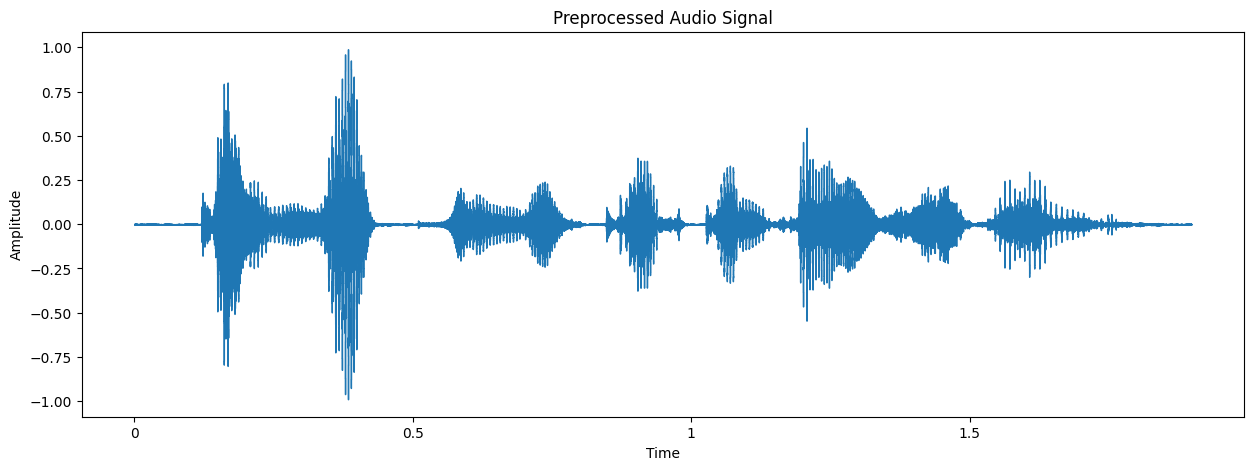

In [10]:
# Lets play a example
fname = EMODB + '/03a01Fa.wav'  
data, sampling_rate = librosa.load(fname)


plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)
plt.title("Preprocessed Audio Signal")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()
# Lets play the audio 
ipd.Audio(fname)

# 2.2 Signal normalization

In [11]:
def preprocess_audio_from_csv(csv_file, output_folder, target_sampling_rate=16000):
    """
    Preprocess audio files listed in a CSV file and save them to a specific folder.

    Parameters:
        csv_file (str): Path to the CSV file containing 'path' and 'source' columns.
        output_folder (str): Folder to save the preprocessed audio files.
        target_sampling_rate (int): Target frequency for resampling audio.
    """
    # Ensure the output folder exists
    os.makedirs(output_folder, exist_ok=True)

    # Read the CSV file
    df = pd.read_csv(csv_file)

    # Filter rows where 'source' == 'EMODB'
    emodb_files = df[df['source'] == 'EMODB']['path']

    for file_path in emodb_files:
        try:
            # Step 1: Load the audio file
            data, sampling_rate = librosa.load(file_path)


            # Step 3: Normalize the signal (zero mean, unit variance)
            data = librosa.util.normalize(data)


            # Save the preprocessed audio file to the output folder with the same name
            output_file = os.path.join(output_folder, os.path.basename(file_path))
            sf.write(output_file, data, samplerate=target_sampling_rate)

            print(f"Processed and saved: {output_file}")
        except Exception as e:
            print(f"Error processing file {file_path}: {e}")

# Example usage
csv_file = 'emodb_features.csv'  # Path to your CSV file
output_folder = 'EMODB_preprocessed'  # Folder to save preprocessed files
preprocess_audio_from_csv(csv_file, output_folder)


Processed and saved: EMODB_preprocessed\03a01Fa.wav
Processed and saved: EMODB_preprocessed\03a01Nc.wav
Processed and saved: EMODB_preprocessed\03a01Wa.wav
Processed and saved: EMODB_preprocessed\03a02Fc.wav
Processed and saved: EMODB_preprocessed\03a02Nc.wav
Processed and saved: EMODB_preprocessed\03a02Ta.wav
Processed and saved: EMODB_preprocessed\03a02Wb.wav
Processed and saved: EMODB_preprocessed\03a02Wc.wav
Processed and saved: EMODB_preprocessed\03a04Ad.wav
Processed and saved: EMODB_preprocessed\03a04Fd.wav
Processed and saved: EMODB_preprocessed\03a04Lc.wav
Processed and saved: EMODB_preprocessed\03a04Nc.wav
Processed and saved: EMODB_preprocessed\03a04Ta.wav
Processed and saved: EMODB_preprocessed\03a04Wc.wav
Processed and saved: EMODB_preprocessed\03a05Aa.wav
Processed and saved: EMODB_preprocessed\03a05Fc.wav
Processed and saved: EMODB_preprocessed\03a05Nd.wav
Processed and saved: EMODB_preprocessed\03a05Tc.wav
Processed and saved: EMODB_preprocessed\03a05Wa.wav
Processed an

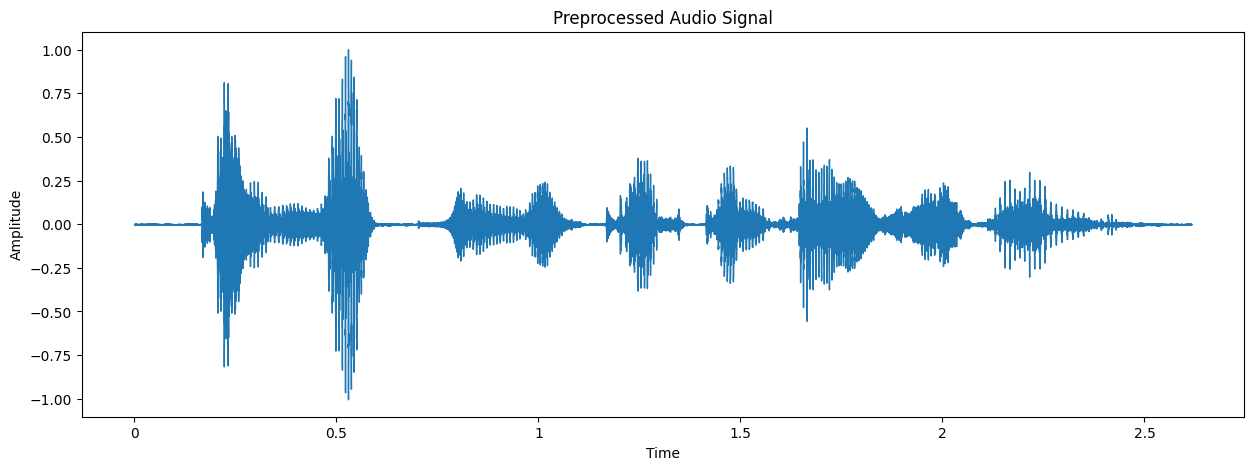

In [12]:

fname = 'EMODB_preprocessed/03a01Fa.wav'  
data, sampling_rate = librosa.load(fname)

plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)
plt.title("Preprocessed Audio Signal")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()
# Lets play the audio 
ipd.Audio(fname)

In [113]:
import librosa
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt
import scipy.ndimage
from pyentrp import entropy as ent
import os
import soundfile as sf
import torch
import torch.nn.functional as F
# Preprocessing
def preprocess_audio(file_path, target_sr=16000):
    """
    Preprocess audio: Convert to mono, resample, and normalize.
    """
    audio, sr = librosa.load(file_path, sr=None, mono=True)
    if sr != target_sr:
        audio = librosa.resample(audio, orig_sr=sr, target_sr=target_sr)
    audio = (audio - np.mean(audio)) / np.std(audio)
    return audio, target_sr

# Constant-Q Transform (CQT)
def compute_cqt(signal, sr, n_bins=96, fmin=100, bins_per_octave=24):
    """
    Compute the Constant-Q Transform (CQT).
    """
    cqt = librosa.cqt(signal, sr=sr, fmin=fmin, n_bins=n_bins, bins_per_octave=bins_per_octave)
    return np.abs(cqt)

# Auditory Neural Pattern Generation
def auditory_neural_pattern(cqt, gamma=10):
    """
    Generate auditory neural patterns from CQT.
    """
    # High-pass filter
    b, a = butter(1, 4.5 / (0.5 * 16000), btype='high')
    high_pass_output = filtfilt(b, a, cqt, axis=1)

    # Non-linear compression
    compressed_output = 1 / (1 + np.exp(-gamma * (high_pass_output - 0.5)))

    # Low-pass filter
    b, a = butter(1, 0.5 / (0.5 * 16000), btype='low')
    low_pass_output = filtfilt(b, a, compressed_output, axis=1)

    return low_pass_output

# Spectro-Temporal Modulation (STM)
def spectro_temporal_modulation(as_pattern, rates=[2, 4, 8, 16, 32, 64, 128, 256]):
    """
    Apply Gabor-like filters to auditory spectrogram (AS) for temporal modulation.
    """
    modulation_map = []
    for rate in rates:
        filtered = scipy.ndimage.gaussian_filter(as_pattern, sigma=(0, rate))
        modulation_map.append(filtered)
    return np.stack(modulation_map, axis=0)

# Integration for STM Features
def integrate_modulation(modulation_map):
    """
    Integrate spectro-temporal modulation over time.
    """
    return np.sum(modulation_map ** 2, axis=2)

def approx_entropy(U, m, r):
    """
    Approximate entropy algorithm.
    
    Parameters:
        U (array-like): Time series.
        m (int): Length of compared runs.
        r (float): Tolerance (standard deviation of the time series multiplied by a factor).

    Returns:
        float: Approximate entropy.
    """
    N = len(U)
    def _phi(m):
        x = np.array([U[i:i + m] for i in range(N - m + 1)])
        C = np.sum(np.abs(x[:, None] - x[None, :]).max(axis=2) <= r, axis=0) / (N - m + 1)
        return np.sum(np.log(C)) / (N - m + 1)
    return abs(_phi(m + 1) - _phi(m))
    
# Entropy Feature Extraction
def compute_entropy_features(signal, m=2, r=0.2):
    """
    Compute Approximate Entropy and Sample Entropy for a given signal.
    """
    approximate_entropy = approx_entropy(signal, m, r)
    sample_entropy = ent.sample_entropy(signal, m, r)
    return approximate_entropy, sample_entropy



# Combined Auditory Feature Extraction
def extract_auditory_features(file_path, target_sr=16000):
    """
    Extract combined auditory features, including STM and entropy features.
    """
    # Preprocess audio
    signal, sr = preprocess_audio(file_path, target_sr)

    # Compute CQT for auditory spectrogram
    cqt = compute_cqt(signal, sr)

    # Generate auditory neural pattern
    as_pattern = auditory_neural_pattern(cqt)

    # Compute spectro-temporal modulation
    modulation_map = spectro_temporal_modulation(as_pattern)

    # Integrate STM features
    stm_features = integrate_modulation(modulation_map).flatten()

    # Compute entropy features
    approximate_entropy, sample_entropy = compute_entropy_features(signal)

    # Combine STM and entropy features
    combined_features = np.hstack((stm_features, approximate_entropy, sample_entropy))

    return combined_features

# Batch Feature Extraction
def batch_feature_extraction(csv_file, output_csv, target_sr=16000):
    """
    Extract features for all audio files listed in a CSV file.
    """
    df = pd.read_csv(csv_file)

    features_list = []
    k=0
    for _, row in df.iterrows():
        file_path = row['path']
        try:
            features = extract_auditory_features(file_path, target_sr)
            features_list.append(features)
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
        print(k)
        k=k+1

    # Save extracted features to a CSV file
    features_df = pd.DataFrame(features_list)
    features_df.to_csv(output_csv, index=False)
    print(f"Features saved to {output_csv}")




In [ ]:

csv_file = 'emodb_features.csv'  # Input CSV file with audio file paths
output_csv = 'emodb_extracted_features5.csv'  # Output CSV file
batch_feature_extraction(csv_file, output_csv)

GPU is available: NVIDIA GeForce RTX 4060 Laptop GPU
CUDA version: 11.8
PyTorch is using device: 0


In [26]:
import torch
import torchaudio
import torchaudio.transforms as T
import numpy as np
import pandas as pd
import torch.nn.functional as F
# Preprocessing
def preprocess_audio(file_path, target_sr=16000, device='cuda'):
    """
    Preprocess audio: Load, resample, and normalize.
    """
    waveform, sr = torchaudio.load(file_path)  # Load audio
    waveform = waveform.to(device)  # Move to GPU
    if sr != target_sr:
        resampler = T.Resample(orig_freq=sr, new_freq=target_sr).to(device)
        waveform = resampler(waveform)
    # Normalize waveform
    waveform = (waveform - waveform.mean()) / waveform.std()
    return waveform, target_sr

# Approximate CQT using STFT
def compute_cqt_approx(signal, sr, n_fft=2048, hop_length=512, bins_per_octave=24, fmin=100, device='cuda'):
    """
    Approximate the Constant-Q Transform (CQT) using STFT.
    """
    # STFT transform
    stft_transform = T.Spectrogram(n_fft=n_fft, hop_length=hop_length, power=None).to(device)
    stft_result = stft_transform(signal)

    # Simulate CQT by binning frequencies
    freqs = torch.linspace(fmin, sr / 2, stft_result.size(1), device=device)
    cqt_bins = torch.logspace(start=np.log10(fmin), end=np.log10(sr / 2), steps=bins_per_octave, device=device)
    cqt_result = torch.zeros((bins_per_octave, stft_result.size(2)), device=device)

    for i in range(1, bins_per_octave):
        mask = (freqs >= cqt_bins[i - 1]) & (freqs < cqt_bins[i])
        cqt_result[i - 1] = stft_result[mask].mean(0)

    return cqt_result

# Spectro-Temporal Modulation
def spectro_temporal_modulation(as_pattern, rates=[2, 4, 8, 16, 32, 64, 128, 256], device='cuda'):
    """
    Apply Gabor-like filters to auditory spectrogram (AS) for temporal modulation.
    """
    modulation_map = []
    for rate in rates:
        blurred = dynamic_gaussian_blur(as_pattern, kernel_size=rate, sigma=rate / 2, device=device)
        modulation_map.append(blurred.squeeze(0).squeeze(0))
    return torch.stack(modulation_map, dim=0)


# Entropy Feature Extraction
# Approximate CQT using STFT
def compute_cqt_approx(signal, sr, n_fft=2048, hop_length=512, bins_per_octave=24, fmin=100, device='cuda'):
    """
    Approximate the Constant-Q Transform (CQT) using STFT and align the output for Gaussian blur input.
    """
    # Compute STFT
    stft_transform = T.Spectrogram(n_fft=n_fft, hop_length=hop_length, power=None).to(device)
    stft_result = stft_transform(signal)  # Shape: (batch, freq, time)

    # Simulate CQT by aggregating frequency bins
    freqs = torch.linspace(0, sr / 2, stft_result.size(1), device=device)  # STFT frequencies
    cqt_bins = torch.logspace(start=np.log10(fmin), end=np.log10(sr / 2), steps=bins_per_octave, device=device)  # CQT bins

    cqt_result = torch.zeros((stft_result.size(0), bins_per_octave - 1, stft_result.size(2)), device=device)

    for i in range(1, len(cqt_bins)):
        # Create frequency mask for this bin
        mask = (freqs >= cqt_bins[i - 1]) & (freqs < cqt_bins[i])
        mask = mask.unsqueeze(0).unsqueeze(-1).expand_as(stft_result)  # Match dimensions of `stft_result`
        cqt_result[:, i - 1, :] = stft_result.masked_select(mask).view(stft_result.size(0), -1, stft_result.size(2)).mean(dim=1)

    # Reshape to match Gaussian blur input requirements: (batch_size, 1, frequency_bins, time_steps)
    cqt_result = cqt_result.unsqueeze(1)  # Add channel dimension
    return cqt_result


# Combined Feature Extraction
def extract_auditory_features(file_path, target_sr=16000, device='cuda'):
    """
    Extract auditory features including STM and entropy features.
    """
    # Preprocess
    signal, sr = preprocess_audio(file_path, target_sr, device=device)

    # Compute CQT
    cqt = compute_cqt_approx(signal, sr, device=device)

    # Generate spectro-temporal modulation
    stm = spectro_temporal_modulation(cqt, device=device)

    # Integrate STM features
    stm_features = stm.pow(2).sum(dim=2).flatten().cpu().numpy()

    # Compute entropy features
    approximate_entropy, sample_entropy = compute_entropy_features(signal.squeeze(), device=device)

    # Combine features
    combined_features = np.hstack((stm_features, approximate_entropy, sample_entropy))
    return combined_features

# Batch Feature Extraction
def batch_feature_extraction(csv_file, output_csv, target_sr=16000, device='cuda'):
    """
    Extract features for all audio files in a CSV file and save results.
    """
    df = pd.read_csv(csv_file)
    features_list = []

    for _, row in df.iterrows():
        file_path = row['path']
        try:
            features = extract_auditory_features(file_path, target_sr, device)
            features_list.append(features)
        except Exception as e:
            print(f"Error processing {file_path}: {e}")

    features_df = pd.DataFrame(features_list)
    features_df.to_csv(output_csv, index=False)
    print(f"Features saved to {output_csv}")



import torch
import torch.nn.functional as F

def gaussian_blur(signal, kernel_size=5, sigma=1.0, device='cuda'):
    """
    Apply Gaussian blur using a convolutional kernel.
    Parameters:
        signal (torch.Tensor): The input tensor, expected to be 2D (frequency, time) or 3D (batch, frequency, time).
        kernel_size (int): Size of the Gaussian kernel.
        sigma (float): Standard deviation for the Gaussian kernel.
        device (str): The device ('cuda' or 'cpu').

    Returns:
        torch.Tensor: The blurred signal.
    """
    # Ensure the signal is 4D (batch_size, channels, height, width) for convolution
    if signal.dim() == 2:  # (frequency, time)
        signal = signal.unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
    elif signal.dim() == 3:  # (batch, frequency, time)
        signal = signal.unsqueeze(1)  # Add channel dimension
    elif signal.dim() != 4:
        raise ValueError("Signal must be 2D, 3D, or 4D tensor for Gaussian blur")

    # Create 1D Gaussian kernel
    coords = torch.arange(kernel_size, device=device).float() - (kernel_size - 1) / 2
    g = torch.exp(-(coords ** 2) / (2 * sigma ** 2))
    g /= g.sum()  # Normalize

    # Create 2D Gaussian kernel
    kernel = g[:, None] * g[None, :]
    kernel = kernel.unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions

    # Move kernel to the same device as the signal
    kernel = kernel.to(signal.device)

    # Pad the input signal
    pad_size = kernel_size // 2
    signal = F.pad(signal, (pad_size, pad_size, pad_size, pad_size), mode='reflect')

    # Perform 2D convolution
    blurred = F.conv2d(signal, kernel, groups=1)
    return blurred.squeeze(0).squeeze(0)  # Remove batch and channel dimensions


def dynamic_gaussian_blur(as_pattern, kernel_size=5, sigma=1.5,device='cuda'):
    """
    Apply Gaussian blur dynamically without using `torch.nn`.

    Parameters:
        as_pattern (torch.Tensor): Input tensor with shape (batch_size, 1, frequency_bins, time_steps).
        kernel_size (int): Initial kernel size (must be odd).
        sigma (float): Standard deviation for the Gaussian kernel.

    Returns:
        torch.Tensor: Blurred tensor.
    """
    # Ensure kernel size is odd
    kernel_size = kernel_size if kernel_size % 2 == 1 else kernel_size + 1

    # Check dimensions of the input tensor
    batch_size, channels, freq_bins, time_steps = as_pattern.shape

    # Adjust kernel size to fit within tensor dimensions
    kernel_size = min(kernel_size, freq_bins, time_steps)

    # Generate a 2D Gaussian kernel
    def gaussian_kernel(size, sigma):
        ax = torch.arange(-size // 2 + 1, size // 2 + 1, dtype=torch.float32)
        xx, yy = torch.meshgrid(ax, ax)
        kernel = torch.exp(-(xx**2 + yy**2) / (2 * sigma**2))
        kernel = kernel / kernel.sum()  # Normalize
        return kernel

    # Create Gaussian kernel
    kernel = gaussian_kernel(kernel_size, sigma).to(as_pattern.device)

    # Expand kernel to match input dimensions (batch size and channels)
    kernel = kernel.expand(channels, 1, kernel_size, kernel_size)  # Shape: (channels, 1, k, k)

    # Apply convolution
    padding = kernel_size // 2
    as_pattern_padded = torch.nn.functional.pad(as_pattern, (padding, padding, padding, padding), mode="reflect")
    blurred_result = torch.nn.functional.conv2d(as_pattern_padded, kernel, groups=channels)

    return blurred_result



In [ ]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

csv_file = 'emodb_features.csv'  # Input CSV file with audio file paths
output_csv = 'emodb_extracted_features.csv'  # Output CSV file
batch_feature_extraction(csv_file, output_csv)

In [31]:
emo = pd.read_csv('emodb_features.csv')
label = emo['emotion_label']

In [32]:
selected_rows = [
    1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,
    21, 24, 25, 30, 46, 47, 48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
    62, 63, 64, 65, 67, 73, 75, 78
]
selected_rows = [i - 1 for i in selected_rows]  # Convert to 0-based indexing
emo_new = pd.read_csv('emodb_extracted_features.csv')
emo_new['selected_emotion_label'] = ''
emo_new['selected_emotion_label'] = emo.loc[selected_rows, 'emotion_label']
# Extract the 'emotion_label' for the selected rows
#emo_new.to_csv('emodb', index=False)

In [ ]:
# New selected rows (add 130 to each index in the list)
updated_selected_rows = [
    2, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 36, 37, 38, 
    39, 40, 41, 44, 52, 55, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 69, 70, 
    71, 80, 81, 82, 83, 84, 88
]

# Add 130 to each index in the list
updated_selected_rows = [i + 130 for i in updated_selected_rows]

emo = pd.read_csv('emodb_features.csv')

# Load the dataset
emo_new4 = pd.read_csv('emodb_extracted_features4.csv')

# Initialize the new column if not already present
emo_new4['selected_emotion_label'] = ''
# Update the 'selected_emotion_label' for the updated selected rows
emo_new4['selected_emotion_label'] = emo.loc[updated_selected_rows, 'emotion_label'].reset_index(drop=True)

# Save the modified DataFrame if needed
# emo_new.to_csv('emodb_updated.csv', index=False)
print(emo.loc[updated_selected_rows, 'emotion_label'])
print(emo_new4)

In [ ]:
print(emo.loc[selected_rows, 'emotion_label'])
df_reindexed = emo.loc[selected_rows, 'emotion_label'].reset_index(drop=True)
df_reindexed = pd.concat([emo.loc[updated_selected_rows, 'emotion_label'], emo.loc[selected_rows, 'emotion_label']], ignore_index=True)
print(df_reindexed)

In [36]:
label_mapping = {
    "happiness": 0,
    "neutral": 1,
    "anger": 2,
    "sadness": 3,
    "fear": 4,
    "boredom": 5
}

# Encode labels
encoded_labels = [label_mapping[label] for label in df_reindexed]

In [37]:
print(encoded_labels)

[0, 1, 2, 0, 1, 3, 2, 2, 4, 0, 5, 1, 3, 2, 0, 1, 2, 2, 1, 1, 2, 4, 0, 5, 1, 2, 2, 4, 4, 0, 5, 1, 2, 0, 5, 1, 2, 0, 1, 2]


In [ ]:


features_df1 = pd.read_csv('emodb_extracted_features.csv')
features_df4 = pd.read_csv('emodb_extracted_features4.csv')
features_df = pd.concat([features_df1, features_df4], ignore_index=True)
print(features_df)
# Convert features to PyTorch tensor
features_tensor = torch.tensor(features_df.values, dtype=torch.float32)

# Normalize features
features_tensor = (features_tensor - features_tensor.mean(dim=0)) / features_tensor.std(dim=0)

# Define a simple CNN for feature extraction
class CNNFeatureExtractor(nn.Module):
    def __init__(self, input_dim):
        super(CNNFeatureExtractor, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.fc = nn.Linear(32 * (input_dim // 4), 50)  # Adjust input_dim // 4 based on pooling

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension for Conv1d
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x

# Initialize CNN
input_dim = features_tensor.shape[1]
#device = torch.device("cpu")
model = CNNFeatureExtractor(input_dim)

# DataLoader for batch processing
dataset = TensorDataset(features_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)




In [103]:
# Extract features using the CNN
model.eval()  # Set model to evaluation mode
extracted_features = []
with torch.no_grad():
    for batch_features in dataloader:
        batch_features = batch_features[0]
        extracted = model(batch_features)
        extracted_features.append(extracted)

# Combine all extracted features
extracted_features = torch.cat(extracted_features, dim=0).cpu().numpy()

# Convert extracted features to DataFrame
extracted_df = pd.DataFrame(extracted_features)

# Merge extracted features with labels

# Save the final DataFrame
output_csv = "cnn_extracted_features_with_labels_83.csv"
extracted_df.to_csv(output_csv, index=False)

print(f"Features and labels saved to {output_csv}.")

Features and labels saved to cnn_extracted_features_with_labels_83.csv.


In [ ]:
last_two_columns = features_df.iloc[:, -2:]
#print(last_two_columns)
df1 = pd.concat([extracted_df, last_two_columns], axis=1)
print(df1)

In [105]:
from sklearn.metrics import hamming_loss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Step 1: Load Data
# Assuming `df` is your 40x52 DataFrame and `labels` is a separate series
df = df1 # Placeholder for 40x52 DataFrame
labels = df_reindexed  # Example labels

# Step 2: Encode Labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
num_classes = len(label_encoder.classes_)

# Step 3: Split Data
X_train, X_test, y_train, y_test = train_test_split(df.values, encoded_labels, test_size=0.2, random_state=42)

# Step 4: Create ECOC Matrix
num_classifiers = 10 * int(np.log2(num_classes))  # As suggested in the Nature paper
np.random.seed(42)
ecoc_matrix = np.random.randint(2, size=(num_classes, num_classifiers)) * 2 - 1  # ECOC matrix with +1/-1

# Step 5: Define Gamma Classifier
def gamma_similarity(x, y, theta=0):
    """
    Gamma similarity operator for binary vectors x and y.
    Returns 1 if similarity condition holds, otherwise 0.
    """
    diff = np.sum((x != y).astype(int))
    return 1 if diff <= theta else 0

class GammaClassifier:
    def __init__(self, positive_class_indices):
        self.positive_class_indices = positive_class_indices
        self.prototype = None

    def fit(self, X, y):
        # Create the prototype vector (average of positive class samples)
        positive_samples = X[np.isin(y, self.positive_class_indices)]
        self.prototype = np.mean(positive_samples, axis=0)

    def predict(self, X):
        predictions = []
        for sample in X:
            predictions.append(gamma_similarity(sample, self.prototype))
        return np.array(predictions)


In [106]:
# Step 6: Train Gamma Classifiers for ECOC Columns
gamma_classifiers = []
for col in range(ecoc_matrix.shape[1]):
    binary_labels = np.where(np.isin(y_train, np.where(ecoc_matrix[:, col] == 1)[0]), 1, -1)
    
    gamma_clf = GammaClassifier(positive_class_indices=np.where(ecoc_matrix[:, col] == 1)[0])
    gamma_clf.fit(X_train, binary_labels)
    gamma_classifiers.append(gamma_clf)

# Step 7: ECOC Prediction
def ecoc_predict(X):
    ecoc_predictions = np.zeros((X.shape[0], len(gamma_classifiers)))
    for idx, gamma_clf in enumerate(gamma_classifiers):
        ecoc_predictions[:, idx] = gamma_clf.predict(X)

    # Decode ECOC predictions using Hamming distance
    predicted_classes = []
    for row in ecoc_predictions:
        distances = [hamming_loss(row, ecoc_matrix[i]) for i in range(ecoc_matrix.shape[0])]
        predicted_classes.append(np.argmin(distances))
    return np.array(predicted_classes)

# Step 8: Evaluate the Model
y_pred = ecoc_predict(X_test)
accuracy = np.mean(y_pred == y_test)
print(f"Accuracy: {accuracy:.4f}")

# Decode the predicted labels to original class names
decoded_predictions = label_encoder.inverse_transform(y_pred)
decoded_actuals = label_encoder.inverse_transform(y_test)

Accuracy: 0.3529


C:\Users\Jeffe\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Jeffe\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


In [ ]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

# Print Evaluation Metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall (weighted): {recall:.4f}")
print(f"F1 Score (weighted): {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)


In [ ]:
class_labels = label_encoder.classes_

# Convert confusion matrix to a DataFrame for better readability

# Get unique classes from y_test
unique_test_classes = np.unique(y_test)

# Get the corresponding class labels
test_class_labels = label_encoder.inverse_transform(unique_test_classes)

# Convert confusion matrix to DataFrame with aligned labels
conf_matrix_df = pd.DataFrame(conf_matrix, index=test_class_labels, columns=test_class_labels)

# Print the labeled confusion matrix
print("Confusion Matrix with Labels:")
print(conf_matrix_df)

In [73]:
#GPU inplementation
# Load the dataset
emo = pd.read_csv('emodb_extracted_features.csv')  # Replace with your dataset
features = emo
# Separate features and labels

labels = encoded_labels

# Convert features to PyTorch tensor
features_tensor = torch.tensor(features.values, dtype=torch.float32)

# Normalize features
features_tensor = (features_tensor - features_tensor.mean(dim=0)) / features_tensor.std(dim=0)

# If labels exist, convert to tensor
if labels is not None:
    label_tensor = torch.tensor(labels, dtype=torch.long)

# Create DataLoader
dataset = TensorDataset(features_tensor) if labels is None else TensorDataset(features_tensor, label_tensor)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

# Define an RNN-based feature extractor
class RNNFeatureExtractor(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, output_dim=50):
        super(RNNFeatureExtractor, self).__init__()
        self.rnn = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)  # Output feature vector size

    def forward(self, x):
        x = x.unsqueeze(1)  # Add a sequence dimension (batch_size, seq_len=1, input_dim)
        _, (hn, _) = self.rnn(x)  # hn is the hidden state from the last time step
        hn = hn[-1]  # Take the last layer's hidden state
        out = self.fc(hn)  # Pass through fully connected layer
        return out




In [74]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import torch.optim as optim
input_dim = features_tensor.shape[1]
model = RNNFeatureExtractor(input_dim=input_dim)

criterion = nn.CrossEntropyLoss() if labels is not None else None
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 10
if labels is not None:
    for epoch in range(epochs):
        for batch_features, batch_labels in dataloader:
            

            # Forward pass
            outputs = model(batch_features)
            loss = criterion(outputs, batch_labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")
extracted_features = []
with torch.no_grad():
    for batch in dataloader:
        batch_features = batch[0].to(device)  # Extract features (ignore labels if present)
        extracted = model(batch_features)
        extracted_features.append(extracted)

extracted_features = torch.cat(extracted_features, dim=0).cpu().numpy()

# Save the extracted features
extracted_df = pd.DataFrame(extracted_features)
if labels is not None:
    extracted_df['emotion_label'] = labels  # Add the emotion labels back
extracted_df.to_csv("rnn_emotion_extracted_features.csv", index=False)

print("Feature extraction completed and saved to rnn_emotion_extracted_features.csv.")

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
